<a href="https://colab.research.google.com/github/manoj-dhakal/machine-learning/blob/main/project_Human_Emotions_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import os
import random
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import cv2
import torch.nn as nn


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parallelopip","key":"89a56872e8b7f32bf4abb2db58e88881"}'}

In [ ]:
! mkdir ~/.kaggle #directory
! cp kaggle.json ~/.kaggle/ #copy it to the directory made

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json #make data readable and writable

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 98% 302M/309M [00:01<00:00, 214MB/s]
100% 309M/309M [00:01<00:00, 188MB/s]


In [ ]:
!unzip /content/human-emotions-datasethes.zip

Streaming output truncated to the last 5000 lines.
  inflating: EmotionsDataset/data/nothing/720.jpg  
  inflating: EmotionsDataset/data/nothing/721.jpg  
  inflating: EmotionsDataset/data/nothing/722.jpg  
  inflating: EmotionsDataset/data/nothing/723.jpg  
  inflating: EmotionsDataset/data/nothing/724.jpg  
  inflating: EmotionsDataset/data/nothing/725.jpg  
  inflating: EmotionsDataset/data/nothing/726.jpg  
  inflating: EmotionsDataset/data/nothing/727.jpg  
  inflating: EmotionsDataset/data/nothing/728.jpg  
  inflating: EmotionsDataset/data/nothing/729.jpg  
  inflating: EmotionsDataset/data/nothing/73.jpg  
  inflating: EmotionsDataset/data/nothing/730.jpg  
  inflating: EmotionsDataset/data/nothing/731.jpg  
  inflating: EmotionsDataset/data/nothing/732.jpg  
  inflating: EmotionsDataset/data/nothing/733.jpg  
  inflating: EmotionsDataset/data/nothing/734.jpg  
  inflating: EmotionsDataset/data/nothing/735.jpg  
  inflating: EmotionsDataset/data/nothing/736.jpg  
  inflating: E

In [ ]:
train_directory = "Emotions Dataset/Emotions Dataset/train/"
test_directory = "Emotions Dataset/Emotions Dataset/test/"


In [ ]:
train_list_angry_paths = []
train_list_sad_paths = []
train_list_happy_paths = []


train_list_angry_paths += os.listdir(str(train_directory)+ "angry/")
train_list_sad_paths += os.listdir(str(train_directory)+ "sad/")
train_list_happy_paths += os.listdir(str(train_directory)+ "happy/")

train_list_angry_paths = [str(train_directory+"angry/") + i for i in train_list_angry_paths]
train_list_happy_paths = [str(train_directory+ "happy/") + i for i in train_list_happy_paths]
train_list_sad_paths = [str(train_directory+ "sad/") + i for i in train_list_sad_paths]



train_data_path = train_list_happy_paths + train_list_angry_paths + train_list_sad_paths
random.shuffle(train_data_path)

test_list_angry_paths = []
test_list_sad_paths = []
test_list_happy_paths = []

test_list_angry_paths += os.listdir(str(test_directory)+ "angry/")
test_list_sad_paths += os.listdir(str(test_directory)+ "sad/")
test_list_happy_paths += os.listdir(str(test_directory)+ "happy/")

test_list_angry_paths = [str(test_directory+"angry/") + i for i in test_list_angry_paths]
test_list_happy_paths = [str(test_directory + "happy/") +i for i in test_list_happy_paths]
test_list_sad_paths = [str(test_directory+ "sad/") + i for i in test_list_sad_paths]



val_ratio = 0.5

test_data_path = test_list_angry_paths + test_list_sad_paths + test_list_happy_paths
random.shuffle(test_data_path)

val_data_path = test_data_path[0:int(len(test_data_path) * val_ratio)]

test_data_path = test_data_path[int(len(test_data_path) * val_ratio): ]

#print(val_data_path)
print(test_data_path)










['Emotions Dataset/Emotions Dataset/test/sad/280844.jpg_brightness_2.jpg', 'Emotions Dataset/Emotions Dataset/test/happy/787569.jpg', 'Emotions Dataset/Emotions Dataset/test/sad/780955.jpg', 'Emotions Dataset/Emotions Dataset/test/happy/151741.jpg', 'Emotions Dataset/Emotions Dataset/test/sad/903454.jpg_brightness_2.jpg', 'Emotions Dataset/Emotions Dataset/test/sad/514503.jpg', 'Emotions Dataset/Emotions Dataset/test/angry/161624.jpg_brightness_2.jpg', 'Emotions Dataset/Emotions Dataset/test/happy/997224.jpg_rotation_2.jpg', 'Emotions Dataset/Emotions Dataset/test/sad/554817.jpg_rotation_2.jpg', 'Emotions Dataset/Emotions Dataset/test/angry/990893.jpg_rotation_1.jpg', 'Emotions Dataset/Emotions Dataset/test/happy/56456.jpg_rotation_2.jpg', 'Emotions Dataset/Emotions Dataset/test/angry/704351.jpg_brightness_1.jpg', 'Emotions Dataset/Emotions Dataset/test/angry/756870.jpg_brightness_1.jpg', 'Emotions Dataset/Emotions Dataset/test/sad/697619.jpg_rotation_2.jpg', 'Emotions Dataset/Emotions

In [ ]:
class Emotions(Dataset):
  def __init__(self, image_filepaths, transform = None):
    self.image_filepaths = image_filepaths
    self.transform = transform

  def __len__(self):
    return len(self.image_filepaths)

  def __getitem__(self, index):

    image = cv2.imread(self.image_filepaths[index])

    if(self.image_filepaths[index].split('/')[3] == 'angry'):
      label = 1
    elif (self.image_filepaths[index].split('/')[3] == 'sad'):
      label = 0
    else:
      label = 2

    if self.transform:
      image = self.transform(image = image)['image']


    return image, label

In [ ]:
IM_SIZE = 224

transform = A.Compose([
                        A.Resize(IM_SIZE, IM_SIZE),
                        A.RandomRotate90(),
                        A.RandomBrightnessContrast(brightness_limit=0.2,
                                                  contrast_limit=0.2,
                                                  always_apply=False, p=0.5),

                        A.OneOf([A.HorizontalFlip(),
                                 A.VerticalFlip(),], p = 0.3), #so that all data are either flipped left or right, to make
                        #data independent of orientation
                        A.Normalize()
                       #normalizes the data


])

In [ ]:
train_dataset = Emotions(train_data_path, transform)
val_dataset = Emotions(val_data_path, transform)
test_dataset = Emotions(test_data_path, transform)
image, label = train_dataset[0]
#print(image)
max= np.max(image)
min= np.min(image)
print("max = ", max)
print("min = ", min)


max =  0.931939
min =  -2.117904


In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True) #returns an iterator,
# you loop over it like this : for batch_data, batch_labels in train_loader:
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False) #not shuffled during test
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)




In [ ]:
image, label =next(iter(test_loader))


Text(112, 254, 'Label: 1')

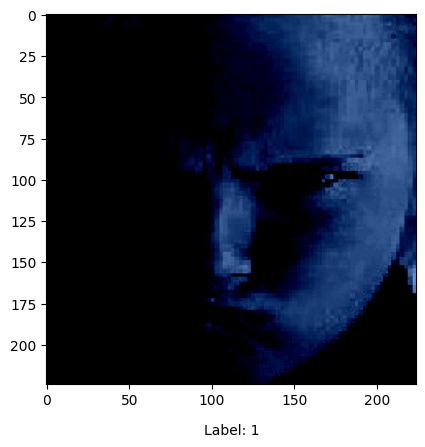

In [ ]:
#visualization
image_h = image[11] #second data of a batch
label_h = label[11] # its label
plt.imshow(image_h)
label_text = "Label: {}".format(label_h)

# Add the label text below the image at the center
plt.text(x=image_h.shape[1] // 2, y=image_h.shape[0] + 30, s=label_text, ha='center')


In [ ]:
if torch.cuda.is_available:
    print("CUDA is available!")
    device = torch.device('cuda')

else:
    print("No GPU found. Training will be done on CPU.")
    device = torch.device("cpu")
print(device)


CUDA is available!
cuda


In [ ]:
#creating a model for CNN, for use cases without sequences, somewhat similar
#to Functional API, using functional subclassing
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        P = 1
        S = 1
        F = 5


        #initial calculation for what the H and W that go inside the first linear layer will be
        H, W, C = image_h.shape

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=C, out_channels=16, kernel_size=F, stride=S, padding=P, device = device),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # after first conv:
        H = int((H + 2 * P -F) / S) + 1
        W = int((W + 2 * P- F) / S) + 1

        #after first pooling
        H = H//2
        W = W//2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1, device = device),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )
         # after second conv:
        H = int((H + 2 * P - (F - 1) - 1) / S) + 1
        W = int((W + 2 * P- (F - 1) - 1) / S) + 1

        #after second pooling
        H = H//2
        W = W//2

        # Define fully connected layers
        self.fc1 = nn.Linear(32 * H * W, 1000, device = device)  # Assuming H and W are 56 after two max-pooling layers
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1000, 100, device = device)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(100, 3, device = device)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        # First Convolutional Block
        x = self.conv_block1(x)

        # Second Convolutional Block
        x = self.conv_block2(x)

        # Flatten
        x = x.reshape((x.shape[0], -1))  # Reshape to (batch_size, 32 * H * W) #flattening

        # Fully Connected Layers
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        #x = self.softmax(x, dim = 1)

        return x

# Create an instance of your model
model = CNN_model()
print(model)

CNN_model(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=93312, out_features=1000, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=3, bias=True)
)


In [ ]:

def round(x):
  _, max_arg = torch.max(x, dim = 1)

  if max_arg == 0:
    return "Sad"
  elif max_arg == 1:
    return "Angry"
  elif max_arg ==2:
    return "Happy"
  else:
    return "Error here"

In [ ]:
model.to(device)

CNN_model(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=93312, out_features=1000, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=3, bias=True)
)

In [ ]:
losses = []
val_losses = []
# Define the training function
def train(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    patience = 3 #for early stopping
    best_val_loss = float("inf")
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        total_correct = 0
        total_samples = 0
        for batch_data, batch_labels in train_loader:
            optimizer.zero_grad()
            batch_data, batch_labels = batch_data.permute(0,3,1,2).to(device), batch_labels.to(device)
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            total_samples += batch_labels.size(0)
            total_correct += (predicted == batch_labels).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = 100.0 * total_correct / total_samples
        losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                batch_data, batch_labels = batch_data.permute(0,3,1,2).to(device), batch_labels.to(device)
                outputs = model(batch_data)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_samples += batch_labels.size(0)
                total_correct += (predicted == batch_labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100.0 * total_correct / total_samples
        val_losses.append(val_loss)

        # Print progress
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {i+1}. Best validation loss: {best_val_loss:.4f}")
            break
train(model, train_loader, val_loader, 10, 0.001) #training this multiple times so that wed don't exhaust the GPU


Epoch 1/10, Train Loss: 0.6275, Val Loss: 0.7543, Train Accuracy: 74.56%, Val Accuracy: 69.53%
Epoch 2/10, Train Loss: 0.5776, Val Loss: 0.7459, Train Accuracy: 76.28%, Val Accuracy: 67.16%
Epoch 3/10, Train Loss: 0.5109, Val Loss: 0.6842, Train Accuracy: 79.00%, Val Accuracy: 71.29%
Epoch 4/10, Train Loss: 0.4799, Val Loss: 0.6721, Train Accuracy: 80.47%, Val Accuracy: 72.34%
Epoch 5/10, Train Loss: 0.4598, Val Loss: 0.6932, Train Accuracy: 81.63%, Val Accuracy: 72.34%
Epoch 6/10, Train Loss: 0.4656, Val Loss: 0.7816, Train Accuracy: 81.53%, Val Accuracy: 65.67%
Epoch 7/10, Train Loss: 0.4296, Val Loss: 0.6849, Train Accuracy: 83.01%, Val Accuracy: 72.26%
Early stopping at epoch 10. Best validation loss: 0.6721


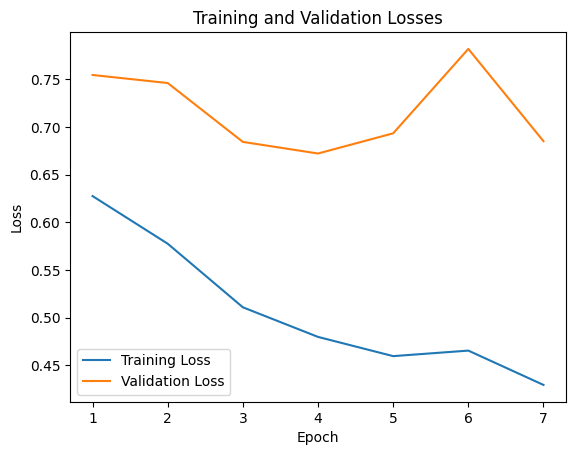

In [ ]:

training_stopped_epoch = 7
# Plotting the losses and validation losses
plt.plot(range(1, training_stopped_epoch+1), losses, label="Training Loss")
plt.plot(range(1, training_stopped_epoch+1), val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()




In [ ]:
#predicting output of one data:
def predict(x, new_image = False): #new image are those images that do not require permutations
  model.eval()

  if len(x.shape) == 3:
    x = x.unsqueeze(0)
  if not new_image:
    x = x.permute(0, 3, 1, 2)

  x = x.to(device)

  pred = model(x)
  return round(pred)


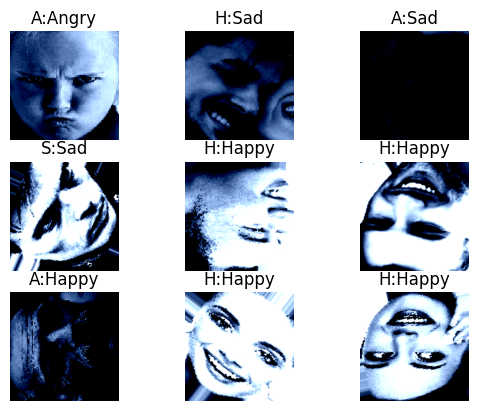

In [ ]:
#visualizing the results
count = 0
for i, (image, label) in enumerate(test_loader):
  if count == 9:
    break
  count+= 1
  random_int = random.randint(0, BATCH_SIZE-1)
  random_image_from_batch = image[random_int]
  label = label[random_int]
  if label ==0:
    correct_answer = "S"
  elif label == 1:
    correct_answer = "A"
  else:
    correct_answer = "H"
  model.eval()
  model_answer = predict(random_image_from_batch)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(random_image_from_batch)
  plt.title(str(correct_answer) + ":" + str(model_answer))
  plt.axis("off")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# save_path = "/content/drive/My Drive/Colab Notebooks/model_checkpoint_emotions.pt"
# # Save the model checkpoint
# torch.save(model.state_dict(), save_path)

In [ ]:
#Accessing saved trained example
save_path = "/content/drive/My Drive/Colab Notebooks/Copy of model_checkpoint_emotions.pt"
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)

'Angry'

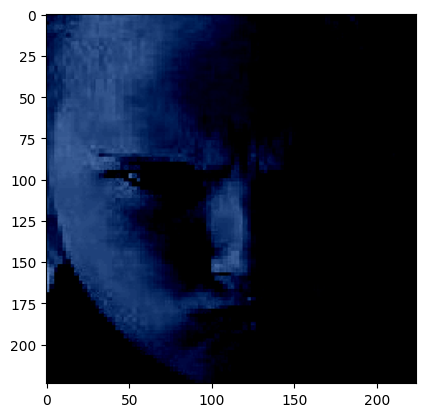

In [ ]:
#predicting images
for image, label in test_loader:
  img, lb = image[11], label[11]
  break

plt.imshow(img)
predict(img)



In [ ]:
#predicting your own images outside of your test set, just a random image:
print(model)
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())



In [ ]:
predict(img)

'Angry'

Saving 105043.jpg to 105043.jpg
The object in the image is:  Angry


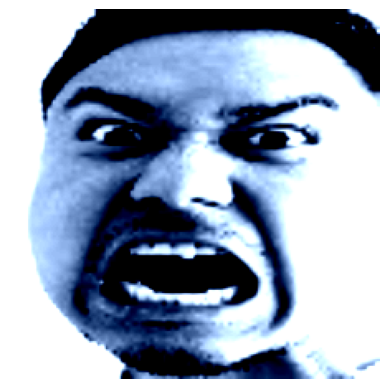

In [ ]:
from PIL import Image
import albumentations as A
import io

IM_SIZE = 224
transform = A.Compose([
                        A.Resize(IM_SIZE, IM_SIZE),
                        A.RandomRotate90(),
                        A.RandomBrightnessContrast(brightness_limit=0.2,
                                                  contrast_limit=0.2,
                                                  always_apply=False, p=0.5),

                        A.OneOf([A.HorizontalFlip(),
                                 A.VerticalFlip(),], p = 0.3), #so that all data are either flipped left or right, to make
                        #data independent of orientation
                        A.Normalize()
                       #normalizes the data
])

# Function to predict the class of an uploaded image
def predict_image(image_content, model, transform, device):
    # Load the image
    image = Image.open(io.BytesIO(image_content)).convert('RGB') #converting the image_content to RGB mode agter opening it using Python Image Library(PIL)

    # Apply albumentations transformations
    augmented = transform(image=np.array(image))
    input_image = augmented['image']
    input_tensor = torch.tensor(input_image, dtype=torch.float).unsqueeze(0).to(device).permute(0, 3, 1,2) #unsqueeze add another dimension accordingly



    pred = predict(input_tensor, new_image = True)

    input_tensor_cpu = input_tensor.cpu()
    augmented_image = input_tensor_cpu.squeeze(0).numpy()


    return pred, augmented_image



# Upload a file and store it in the current working directory of Colab
uploaded = files.upload()
file_name = list(uploaded.keys())[0]  # Get the uploaded file's name
image_content = uploaded[file_name]    # Get the content of the uploaded file as bytes

# Assuming you have a device (CPU or GPU) defined earlier, use it here
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make a prediction on the uploaded image
pred, augmented_image = predict_image(image_content, model, transform, device)

# Print or display the prediction result
print("The object in the image is: ", pred)

# Transpose the augmented_image to the format (height, width, channels)
augmented_image = augmented_image.transpose(1, 2, 0) #changing from 3, 224, 224 to 224, 224, 3 which plt expects us to do

# Clip the values to be within [0, 1] in case of normalization
augmented_image = np.clip(augmented_image, 0, 1)

# Display the augmented image using plt.imshow()
plt.imshow(augmented_image)
plt.axis('off')  # Turn off axis labels
plt.show()



In [ ]:

#USING RESNET ON THE MODEL

from torchvision import models
model_r = models.resnet18(pretrained=True)
num_ftrs = model_r.fc.in_features
model_r.fc = nn.Linear(num_ftrs,3)
print(model_r)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#PASSING model_r instead of model to the function
losses = []
val_losses = []
# Define the training function
def train(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    patience = 3 #for early stopping
    best_val_loss = float("inf")
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        total_correct = 0
        total_samples = 0
        for batch_data, batch_labels in train_loader:
            optimizer.zero_grad()
            batch_data, batch_labels = batch_data.permute(0,3,1,2).to(device), batch_labels.to(device)
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            total_samples += batch_labels.size(0)
            total_correct += (predicted == batch_labels).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = 100.0 * total_correct / total_samples
        losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                batch_data, batch_labels = batch_data.permute(0,3,1,2).to(device), batch_labels.to(device)
                outputs = model(batch_data)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_samples += batch_labels.size(0)
                total_correct += (predicted == batch_labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100.0 * total_correct / total_samples
        val_losses.append(val_loss)

        # Print progress
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {i+1}. Best validation loss: {best_val_loss:.4f}")
            break
train(model_r, train_loader, val_loader, 10, 0.001) #training this multiple times so that wed don't exhaust the GPU


Epoch 1/10, Train Loss: 0.3925, Val Loss: 0.5241, Train Accuracy: 84.51%, Val Accuracy: 81.21%
Epoch 2/10, Train Loss: 0.3756, Val Loss: 0.5409, Train Accuracy: 85.29%, Val Accuracy: 79.10%
Epoch 3/10, Train Loss: 0.3676, Val Loss: 0.4304, Train Accuracy: 85.66%, Val Accuracy: 84.11%
Epoch 4/10, Train Loss: 0.3341, Val Loss: 0.4840, Train Accuracy: 87.29%, Val Accuracy: 84.20%
Epoch 5/10, Train Loss: 0.3176, Val Loss: 0.5136, Train Accuracy: 87.51%, Val Accuracy: 82.53%
Epoch 6/10, Train Loss: 0.3153, Val Loss: 0.4163, Train Accuracy: 87.94%, Val Accuracy: 85.16%
Epoch 7/10, Train Loss: 0.2904, Val Loss: 0.4715, Train Accuracy: 88.60%, Val Accuracy: 83.23%
Epoch 8/10, Train Loss: 0.2814, Val Loss: 0.4632, Train Accuracy: 89.22%, Val Accuracy: 84.37%
Epoch 9/10, Train Loss: 0.2685, Val Loss: 0.4555, Train Accuracy: 89.51%, Val Accuracy: 83.58%
Early stopping at epoch 10. Best validation loss: 0.4163


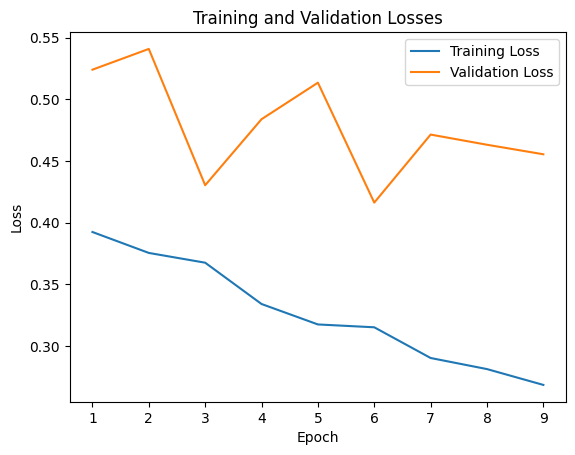

In [ ]:

training_stopped_epoch = 9
# Plotting the losses and validation losses
plt.plot(range(1, training_stopped_epoch+1), losses, label="Training Loss")
plt.plot(range(1, training_stopped_epoch+1), val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()




In [ ]:
#TESTING ACCURACY FOR THE RESNET MODEL

criterion = nn.CrossEntropyLoss()
model_r.eval()
test_loss = 0.0
total_correct = 0
total_samples = 0
with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        batch_data, batch_labels = batch_data.permute(0,3,1,2).to(device), batch_labels.to(device)
        outputs = model_r(batch_data)
        loss = criterion(outputs, batch_labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_samples += batch_labels.size(0)
        total_correct += (predicted == batch_labels).sum().item()
test_loss /= len(test_loader)
test_accuracy = 100.0 * total_correct / total_samples


# Print progress
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.4380, Test Accuracy: 83.32%


In [ ]:
#TESTING ACCURACY FOR THE NORMAL MODEL
criterion = nn.CrossEntropyLoss()
model.eval()
test_loss = 0.0
total_correct = 0
total_samples = 0
with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        batch_data, batch_labels = batch_data.permute(0,3,1,2).to(device), batch_labels.to(device)
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_samples += batch_labels.size(0)
        total_correct += (predicted == batch_labels).sum().item()
test_loss /= len(test_loader)
test_accuracy = 100.0 * total_correct / total_samples


# Print progress
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.6457, Test Accuracy: 73.75%


In [ ]:
save_path = "/content/drive/My Drive/Colab Notebooks/resnet_model_checkpoint_emotions.pt"
# Save the model checkpoint
torch.save(model.state_dict(), save_path)

In [ ]:
#making a Confusion Matrix for test predictions
from sklearn.metrics import confusion_matrix


model_r.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for m in test_loader:
        test_x = m[0].to(device).permute(0, 3, 1, 2)
        test_y = m[1].to(device)


        test_pred = model_r(test_x)

        # Get the predicted class by taking the index of the maximum value in each prediction
        _, predicted_class = torch.max(test_pred, dim=1)

        all_predictions.extend(predicted_class.tolist())
        all_targets.extend(test_y.tolist())

# Convert lists to torch tensors
all_predictions = torch.tensor(all_predictions)
all_targets = torch.tensor(all_targets)

# Calculate the confusion matrix
cm = confusion_matrix(all_targets, all_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)
print("Total data = ", len(test_loader)* 32)


Confusion Matrix:
[[306  49  27]
 [ 27 207   5]
 [ 56  41 421]]
Total data =  1152
